# Image Preprocessing
The act of preprocessing images used to be a very important and delicate art form. The quality of image preprocessing used to almost entirely dictate the success of the subsequent image analysis techniques. While, the advent of deep neural networks has diminished the importance image preprocessing, image preprocessing can still play an important role.

## Goals
This notebook will provide an brief introduction to computer image manipulation. First images will be introduced as tensors. Then building on the tensor description of images, some key augmentations will be presented. These augmentations form the basis of image preprocessing, and a solid grasp of these methods will help in deciding how to preprocess images. Finally a high-level API from the Keras library will be introduced which provides a user friendly method to quickly augment images.

## What is an image?
Before diving into the deep waters of image preprocessing, it is helpful to take a look at what an image is in terms of computer vision. Here we will load an image from the web using a basic image analysis library and begin to understand how a computer thinks about an image.

### Step 1. Load an image from a url

In [1]:
#Import the necessary modules
import requests #http library we will use to get images from the web
import skimage #scikit learn for image analysis
from skimage import io as imageIO #module used to load images need to change the name to avoid conflicts
import io #A python standard library for making in-memory objects that behave like files
import matplotlib.pyplot as plt #a plotting library to view the image with
%matplotlib inline
import numpy as np #the famous numpy library for data array manipulations


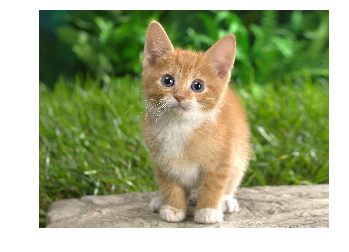

In [2]:
url = 'https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/cat.jpg' #image location
r = requests.get(url) #perform an HTTP GET to obtain the image
if r.status_code == 200: #if the GET request is successful
    b = io.BytesIO(r.content) #store the image data in an io object
    img = imageIO.imread(b) #use PIL to open the .jpg image
    plt.imshow(img) #use matplotlib to display the image
    plt.axis('off') #tell matplotlib not to show graph axis

### Step 2. Examine the image
Now that you have an image stored in the object 'img', lets take a closer look at how that image is being stored in memory.


In [3]:
cat_array = np.array(img) #store the image as a numpy array so that it can be observed
print("The shape of the image is: ", cat_array.shape)
print("The maximum value in the image is: ", cat_array.max())
print("The minimum value in the image is: ", cat_array.min())

The shape of the image is:  (1200, 1600, 3)
The maximum value in the image is:  255
The minimum value in the image is:  0


#### Image format
As the above code snippet shows, the standard format for an image is a 3-dimensional array. The first dimension is the height of the image (in pixels). The second dimension is the width of the image (in pixels), and the third dimension stores the color values of each pixel. **Note** that in images, the origin (0, 0) point is the upper left corner of the image.

#### Color
The color values of a pixel are generally expressed as red, green, and blue (RGB) values. As the above code demonstrated, these values are often an 8 bit positive integer meaning that they can be between 0 and 255. If the image is a black and white image, then the third dimension will have only one 8 bit value. It should be noted that not all images use a single byte for the color channels. One example would be satellite imagery which can have more depth to the color channels.

#### Common image terms
* **Resolution**: the number of pixels in each dimension of the image. Higher resolution images can capture more detail than lower resolution images at the cost of compute and storage.
* **Color channel**: A dimension of the image representing a single 'color'
* **Color depth**: the number of bits in the color channels
* **Color model**: the manner in which the color information is encoded (eg. RGB or HSV)

### Aside on color models

Take the cat image we downloaded earlier as an example. Suppose that we were concerned that the image was too dark to see the cat appropriately (not actually the case but suppose...). In the RGB color model, it's not immediately obvious how to change the values in the image array in order to get a brighter image without affecting the image colors. In this example, the HSV (hugh, saturation, and value) color model really shines. Let's see how.

The shape of the image is:  (1200, 1600, 3)
The maximum value in the value channel is:  1.0
The minimum value in the value channel is:  0.0352941176471


(-0.5, 1599.5, 1199.5, -0.5)

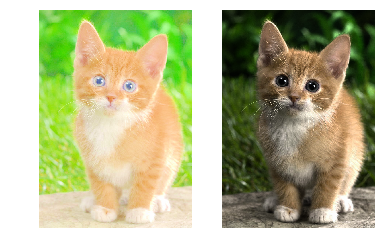

In [4]:
cat_hsv = skimage.color.convert_colorspace(img, 'RGB', 'HSV') #convert from RGB to HSV
print("The shape of the image is: ", cat_array.shape)
#show that the value color channel is now between 0 and 1
print("The maximum value in the value channel is: ", cat_hsv[:,:,-1].max())
print("The minimum value in the value channel is: ", cat_hsv[:,:, -1].min()) 

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True) #setup a subplot to show two images side-by-side
# a lighter cat image
tmp = cat_hsv.copy() #copy to avoid references
tmp[:, :, -1] = tmp[:, :, -1]**0.2 #using a power ensures the values remain between 0 and 1
tmp = skimage.color.convert_colorspace(tmp, 'HSV', 'RGB') #need to convert back to show the image
ax1.imshow(tmp)
ax1.axis('off')

#a darker cat image
tmp = cat_hsv.copy()
tmp[:, :, -1] = tmp[:, :, -1]**2 #using a power ensures the values remain between 0 and 1
tmp = skimage.color.convert_colorspace(tmp, 'HSV', 'RGB') #need to convert back to show the image
ax2.imshow(tmp)
ax2.axis('off')

## How to manipulate an image

Here we will examine a number of common image manipulation tasks similar to the lightening or darkening of an image explored in the Aside above. The goal of this section is to provide some comfort with how to manipulate images by thinking of the images as a 3-dimensional array.

### Cropping
Most image analysis models require the input images to all have a certain resolution. This enables the model to know *a priori* what to expect for its input. This can guaruantee that sufficient resources are available to handle the computational tasks.

300 900 500 1100


(-0.5, 599.5, 599.5, -0.5)

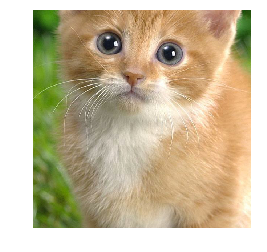

In [5]:
# crop the image from the center
width = 600
height = 600 #change these to get a different crop size
h_c, w_c = img.shape[:-1]
h_c = h_c // 2
w_c = w_c // 2
h_offset = height//2
w_offset = width//2 #change these to crop somewhere off of center
h_start = h_c - h_offset
h_end = h_start + height
w_start = w_c - w_offset
w_end = w_start + width
print(h_start, h_end, w_start, w_end)
tmp = cat_array[h_start:h_end, w_start:w_end, :]
plt.imshow(tmp)
plt.axis('off')

### Rotation
At the heart of rotation is the your long lost friend the rotation matrix.
$$
\begin{bmatrix}
    cos\left(\theta\right) & -sin\left(\theta\right) \\
    sin\left(\theta\right) & cos\left(\theta\right) \\
\end{bmatrix}
$$
To rotate an image, this matrix can be applied to each pixel location to find the new location of that pixel. However, the discrete nature of images, leads to a problem called aliasing. The images below show how this problem causes certain pixels to be completely missed in the new image which is not ideal:
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/tigger.png">
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/tigger_rotated.png">

A second difficulty in image rotation is that the image is rectangular. This means that when rotated, the image will no longer completely fill the screen. Various padding methods can be used to mitigate this problem, but none are necessarily ideal.

Thankfully, software has been written to deal with aliasing and clipping. In skimage there are a number of options which can be used for clipping: 
mode : {‘constant’, ‘edge’, ‘symmetric’, ‘reflect’, ‘wrap’}

(-0.5, 1599.5, 1199.5, -0.5)

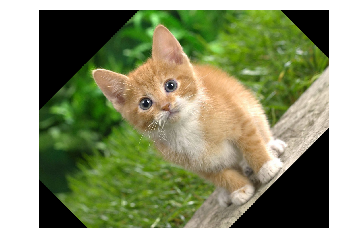

In [6]:
from skimage import transform
tmp = transform.rotate(img, 45, mode='constant') #change the mode to see how it affects the image
plt.imshow(tmp)
plt.axis('off')

### Shear

Shear effects have similar complications to image rotations. We will not spend much time discussing them here. Instead an example of shearing an image using skimage is provided.

(-0.5, 1599.5, 1199.5, -0.5)

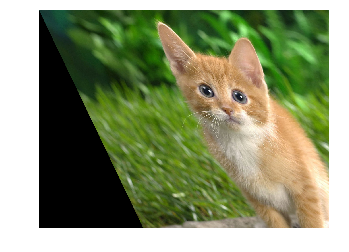

In [7]:
tmp = transform.AffineTransform(shear=0.5)
tmp = transform.warp(img, inverse_map=tmp)
plt.imshow(tmp)
plt.axis('off')

## Putting it all together

The above image manipulation tactics are the heart of image preprocessing. Whenever preprocessing images, the process is the same. Apply mathematical manipulations to the array representation of the image to produce the desired outputs. 

### Leveraging Keras for image preprocessing
Keras has an image generator that can automatically apply a number of preprocessing steps to the images. Below we will explore this functionality.

In [14]:
from keras.preprocessing import image


gen = image.ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None) #alter the values here to see the effect on the image
flow = gen.flow(cat_array.reshape((1, 1200, 1600, 3)), np.array([1]), batch_size=2)

(-0.5, 1599.5, 1199.5, -0.5)

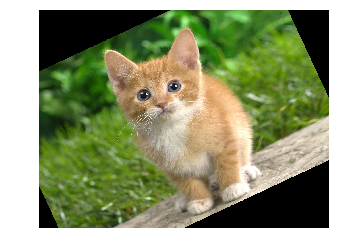

In [16]:
tmp = flow.next()[0].reshape((1200, 1600, 3))

plt.imshow(tmp.astype(np.uint8)) #matplotlib only understands the color mode if the data type is uint8
plt.axis('off')

## A final note on normalization

We didn't discuss parameter normalization up to this point. The reason being that normalized images are not as nice to look at for humans. Computers trying to optimize a neural network however appreciate the normalized input. The reason for this is the same in computer vision as it is in other neural network areas: the gradient descent methods are easier to optimize with normalized parameters. The image below demonstrates how having normalized inputs makes the job of optimization easier.

<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/sgd_normaliztion.png">